In [2]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.21.* skorch

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import time
import pandas as pd

from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit

from skorch.helper import SliceDataset



In [4]:
# Check CPU/GPU
USE_CUDA = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  USE_CUDA = 1
  print(f"Nvidia Cuda/GPU is available!")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Nvidia Cuda/GPU is available!
Mon Dec  7 13:42:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                          

# Load Data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [6]:
# can't upload input data files to Github because it's too big? 
# so each of us will need to change this to where we store data on google drive

%cd '/content/gdrive/MyDrive/Colab/ECSE551Miniproject/Mini-Project3'

/content/gdrive/MyDrive/Colab/ECSE551Miniproject/Mini-Project3


(60000, 64, 128) (60000, 1)


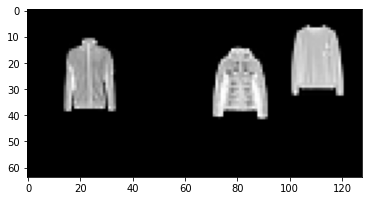

In [7]:
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( './Train.pkl', 'rb' ), encoding='float32')
targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]-5
plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
print(data.shape, targets.shape)

In [8]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
class MyDataset(Dataset):
    
    def __init__(self, img_file, label_file, transform=None, idx = None):
      """function load training or testing data"""

      # read out img_file (.pkl)
      self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')

      # read out label_file (.csv)
      self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]-5

      if idx is not None:
        # idx: binary vector for creating training and validation set.
        # Only return samples where idx is not None

        # set idx for target
        self.targets = self.targets[idx]
        # set idx for data
        self.data = self.data[idx]

      # transform to normalize images
      self.transform = transform

    def __len__(self):
      """function to get len of target"""

      return len(self.targets)

    def __getitem__(self, index):
      """function to get img and target"""

      # get img and target
      img, target = self.data[index], int(self.targets[index])
      img = Image.fromarray(img.astype('uint8'), mode='L')
      
      # doing transform to normalize images
      if self.transform is not None:
        img = self.transform(img)

      return img, target

class TestDataset(Dataset):
    
    def __init__(self, img_file, transform=None, idx = None):
      """function load training or testing data"""

      # read out img_file (.pkl)
      self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')

      if idx is not None:
        # idx: binary vector for creating training and validation set.
        # Only return samples where idx is not None

        # set idx for data
        self.data = self.data[idx]

      # transform to normalize images
      self.transform = transform

    def __len__(self):
      """function to get len of target"""

      return len(self.data)

    def __getitem__(self, index):
      """function to get img and target"""

      # get img and target
      img = self.data[index]
      img = Image.fromarray(img.astype('uint8'), mode='L')
      
      # doing transform to normalize images
      if self.transform is not None:
        img = self.transform(img)

      return img
  

In [10]:
# Read image data and their label into a Dataset class
# Test a portion!! by changing idx!!
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))

# Read Test data (10000)
test_final = TestDataset('./Test.pkl',transform=img_transform, idx=np.arange(10000))

In [11]:
# prepare y_data for sklearn to work
y_data = np.array([y for x, y in iter(dataset)])

# Fit a CNN

In [12]:
# Imports
"""
Code Reference: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/CNN_architectures
"""

# hyperparameter 
drop_ratio = 0.25
kernel_size_CNN = (3,3)

# declare number of input and class label
num_in =1
num_class = 9

VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

# VGG_net class inherits from nn.Module class
class VGG_net(nn.Module):

    def __init__(self, in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]):
      """constructor"""

      # Call the __init__() function of nn.Module class
      super(VGG_net, self).__init__()
      
      # creating neural network
      # (1) convolutional neural network
      self.in_channels = in_channels
      self.conv_layers = self.create_conv_layers(VGG_type)

      # (2) fully connected neural network
      self.fcs = nn.Sequential(
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p = drop_ratio),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p = drop_ratio),
          nn.Linear(4096, num_classes),
      )

    def create_conv_layers(self, architecture):
      """function help to create convolutional neural network"""

      # list for layers
      layers = []

      # define number of input channel
      in_channels = self.in_channels

      # for loop to construct convolutional neural network according to architecture
      for x in architecture:
          if type(x) == int:
              # create output channel number (when it is not Maxpooling)
              out_channels = x

              # add layer with parameter with convolutional neural network
              layers += [
                  nn.Conv2d(
                      in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size = (3,3),
                      stride=(1, 1),
                      padding=(1, 1),
                  ),

                  # Batchnorm to improve performance
                  nn.BatchNorm2d(x),
                  nn.ReLU(),
              ]

              # input channel for next input
              in_channels = x

          elif x == "M":
            # Maxpooling
            layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

      return nn.Sequential(*layers)
        
    def forward(self, x):
      """create forward path for VGG"""
      
      # convolutional neural network
      x = self.conv_layers(x)
      x = x.reshape(x.shape[0], -1)

      # fully connected neural network
      x = self.fcs(x)

      # softmax at the last output layer to get result
      m = nn.Softmax(dim = 1)
      return m(x)

In [13]:
#load model from previous tests or train a new model

Loading_flag = False

if (Loading_flag):
  #  initalization
  network = VGG_net().to(device)
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
  checkpoint = torch.load("./model_trained_1126.tar")

  # load network 
  network.load_state_dict(checkpoint['model_state_dict'])

  # load optimizer 
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  network.train()
else: 
  network = VGG_net().to(device)
  #optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)


print (network)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [14]:
#setting up skorch NeuralNetClassifier with Callbacks

from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skorch.callbacks import Callback

class Monitor(Callback):
    def on_epoch_end(self, net, **kwargs):
         print('learning rate =',net.optimizer_.param_groups[0]['lr'])

callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                     ))
    ]

drop_ratio=0
kernel_size_CNN=(4,4)

torch.manual_seed(0)
network = VGG_net().to(device)

print (device)
cnn = NeuralNetClassifier(
    network,
    max_epochs=20,
    lr=1e-4,
    optimizer=torch.optim.Adam,
    batch_size=32,
    device=device,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    callbacks=callbacks,
    train_split=CVSplit(3)
)

cuda


In [15]:
#fit a VGG net with skorch

import time 

#fit
startall = time.time()
cnn.fit(dataset, y=y_data)
endall = time.time()

print(f"Execution Time: {endall-startall:.2f} s")


learning rate = 0.0001
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4790       0.5452        1.1788  90.1478


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9865       0.7497        0.7988  90.2687
learning rate = 0.0001
      3        0.6938       0.7950        0.7025  90.3246
learning rate = 0.0001
      4        0.5059       0.8617        0.4991  90.2094
learning rate = 0.0001
      5        0.3726       0.8720        0.4669  89.9373
learning rate = 0.0001
      6        0.2909       0.8854        0.4163  90.0045
learning rate = 0.0001
      7        0.2364       0.9030        0.3837  90.5535
learning rate = 0.0001
      8        0.1926       0.8868        0.4564  90.5174
learning rate = 0.0001
      9        0.1611       0.9224        0.3189  90.3028
learning rate = 0.0001
     10        0.1393       0.9034        0.3678  90.3003
learning rate = 0.0001
     11        0.1204       0.9084        0.4434  90.0106
learning rate = 1e-05
     12        0.0528       0.9473        0.2340  90.3879
learning rate = 1e-05
     13        0.0269       0.9493        0.2412  90.1242
learning rate = 1e-05
     14 

In [ ]:
# save trained model

print ("save network \n")
torch.save({
      'model_state_dict': network.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      }, 'model_trained_VGG_16_lr1e-4_80epochs_lr-5_20epochs_lr1e-6_15epochs_1129.tar', _use_new_zipfile_serialization=False)

save network 



# Grid Search

Grid search template with skorch. We did not use these for tests in the end, due to very long training time.

In [ ]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDataset

cnn.set_params(max_epochs=5, verbose=False, train_split=False, callbacks=[])

#parameters to grid search
uni_kernel_test = [3, 5, 7]

params = {
    'module_uni_kernel': uni_kernel_test,
}

cnn.initialize();

gs = GridSearchCV(cnn, param_grid=params, scoring='accuracy', verbose=1, cv=3)

data_train_sliceable = SliceDataset(dataset)

gs.fit(data_train_sliceable, y_data)

The sizes of 1st fully connected input:  7540
Fitting 3 folds for each of 3 candidates, totalling 9 fits
The sizes of 1st fully connected input:  7540


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 19.1min finished


The sizes of 1st fully connected input:  7540
The sizes of 1st fully connected input:  7540


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cnn(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.25, inplace=False)
    (fc1): Linear(in_features=7540, out_features=2000, bias=True)
    (fc2): Linear(in_features=2000, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=15, bias=True)
    (fc1_drop): Dropout(p=0.25, inplace=False)
  ),
),
             iid='warn', n_jobs=None,
             param_grid={'module_uni_kernel': [3, 5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

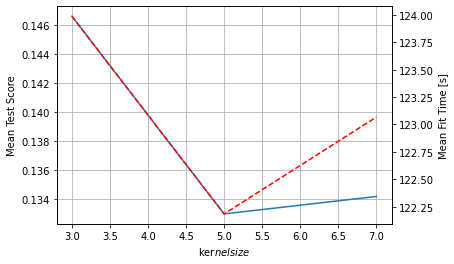

In [ ]:
# Plot results
parameter_plot = uni_kernel_test

save_fig = False
fig, ax = plt.subplots()
ax.plot(parameter_plot, gs.cv_results_["mean_test_score"])
#ax.set_xscale("log")
ax.set_xlabel(r"$\kernel size$")
ax.set_ylabel("Mean Test Score")
ax.grid()

ax2 = ax.twinx()
ax2.plot(parameter_plot, gs.cv_results_["mean_fit_time"], color="r", linestyle="--")
ax2.set_ylabel("Mean Fit Time [s]")

if save_fig:
  plt.tight_layout()
  plt.savefig("alpha_grid_search.pdf", bbox_inches="tight", pad_inches=0)

In [ ]:
cnn.optimizer_.param_groups[0]['lr']

AttributeError: ignored

# Test batch size and learning rate

Fixed parameters: 
- VGG-16
- drop ratio = 0.25
- Optimizer = Adam, no weight decay
- epochs = 20

Testing parameters:
- batch size = 32, 64, 128
- learning rate = 5e-5, 1e-4, 5e-4 (fixed)
- find corrolation of these two parameters

In [ ]:
batch_size_pool = [32, 64, 128]
learning_rate_pool = [5e-5, 1e-4, 5e-4]
batch_size = []
learning_rate = []
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []
callbacks = []

for b_size in batch_size_pool:

  for l_r in learning_rate_pool:

    network = VGG_net().to(device)
    torch.manual_seed(0)
    cnn = NeuralNetClassifier(
        network,
        max_epochs=20,
        lr=l_r,
        optimizer=torch.optim.Adam,
        batch_size=b_size,
        device=device,
        iterator_train__num_workers=4,
        iterator_valid__num_workers=4,
        callbacks=callbacks,
    )
    print(f"fitting with batch size of {cnn.get_params()['batch_size']} and learning rate of {cnn.get_params()['lr']}")

    startall = time.time()
    cnn.fit(dataset, y=y_data)
    endall = time.time()
    timeall = endall-startall

    train_loss.append(np.min(cnn.history[:, 'train_loss']))
    valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
    valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
    dur.append(np.average(cnn.history[:, 'dur']))
    batch_size.append(b_size)
    learning_rate.append(l_r)
    total_time.append(timeall)
    
    print(f"batch size: {b_size}")
    print(f"learning rate: {l_r}")
    print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
    print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
    print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
    print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
    print(f"Total Time: {timeall:.2f} s")




fitting with batch size of 32 and learning rate of 5e-05
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.4992       0.4901        1.3817  103.0763
      2        0.9839       0.7039        0.9065  102.9231
      3        0.5850       0.8562        0.4865  103.2315
      4        0.3940       0.8708        0.4386  103.3250
      5        0.2953       0.8857        0.4136  102.7297
      6        0.2319       0.8971        0.4070  102.8143
      7        0.1939       0.8921        0.4122  102.7355
      8        0.1623       0.9135        0.3290  102.7239
      9        0.1373       0.8871        0.4566  102.9640
     10        0.1203       0.9198        0.3336  102.8465
     11        0.1061       0.9080        0.4418  102.5042
     12        0.0998       0.9259        0.3184  102.7741
     13        0.0882       0.9250        0.3209  103.0276
     14        0.0804       0.9181        0.3893  103.0757

Observation on the side: 
- Batch size 32, learning rate 5e-5, max accuracy starts to oscillate as early as epoch #6.
- Batch size 64, learning rate 5e-5, did some crazy jumping around
- max valid accuracy sometimes doesn't occur at min valid loss

In [ ]:
epochs =[20, 17, 19, 18, 20, 15, 15, 20, 20]

rawdata= {'batch_size': batch_size,'learning_rate': learning_rate, 'train_loss': train_loss, 
          'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 
          'total_time': total_time, 'best_result_epoch': epochs}
bsize_lr = pd.DataFrame(rawdata, columns = ['batch_size','learning_rate','train_loss',
                                            'valid_loss','valid_acc','time/epoch','total_time', 'best_result_epoch'])


   batch_size  learning_rate  ...   total_time  best_result_epoch
0          32        0.00005  ...  2064.220238                 20
1          32        0.00010  ...  2067.452497                 17
2          32        0.00050  ...  2066.282730                 19
3          64        0.00005  ...  1739.201634                 18
4          64        0.00010  ...  1740.548820                 20
5          64        0.00050  ...  1740.824659                 15
6         128        0.00005  ...  1582.125470                 15
7         128        0.00010  ...  1583.204564                 20
8         128        0.00050  ...  1582.344212                 20

[9 rows x 8 columns]


In [ ]:
bsize_lr

,batch_size,learning_rate,train_loss,valid_loss,valid_acc,time/epoch,total_time,best_result_epoch
0,32,0.00005,0.050363,0.288374,0.940530,103.059026,2064.220238,20
1,32,0.00010,0.068600,0.222368,0.955606,103.225540,2067.452497,17
2,32,0.00050,0.429096,0.508961,0.879310,103.162889,2066.282730,19
3,64,0.00005,0.052184,0.362909,0.916542,86.879967,1739.201634,18
4,64,0.00010,0.052723,0.280774,0.944028,86.950756,1740.548820,20
5,64,0.00050,0.305316,0.437553,0.878561,86.960360,1740.824659,15
6,128,0.00005,0.049694,0.426403,0.900800,79.064400,1582.125470,15
7,128,0.00010,0.052722,0.276676,0.936032,79.117939,1583.204564,20
8,128,0.00050,0.375493,0.402139,0.902216,79.075103,1582.344212,20


In [ ]:
bsize_lr.to_csv("bsize_lr.csv",index=False, header=True)

In [ ]:
np.max(cnn.history[:, 'valid_acc'])

0.8071797434616025

In [ ]:
drop_ratio

0.25

# Test dropout ratio



Fixed parameters:
- VGG-16
- batch size = 32
- Optimizer = Adam, no weight decay
- learning rate = 1e-4

Testing parameters:
- drop ratio = 0, 0.1, 0.25, 0.3, 0.5
- changing epochs and learning rate to better understand the results
- added 5-fold cross-validate to obtain reliable results

### Tests with dropout ratio for different epochs

#### 20 epochs, fixed lr=1e-4

In [ ]:
drop_ratio_pool = [0, 0.1, 0.25, 0.3, 0.5]
dropout_ratio = []
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []
callbacks = []

for dr in drop_ratio_pool:

  drop_ratio=dr

  network = VGG_net().to(device)
  torch.manual_seed(0)
  cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
  )
  print(f"fitting with drop ratio of {dr}")

  startall = time.time()
  cnn.fit(dataset, y=y_data)
  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  dropout_ratio.append(dr)
  total_time.append(timeall)
    
  print(f"drop ratio: {drop_ratio}")
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")


fitting with drop ratio of 0
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.4777       0.5177        1.3133  104.0150
      2        0.9358       0.7778        0.7335  103.9541
      3        0.6068       0.8380        0.5591  104.1988
      4        0.4183       0.8731        0.4480  104.2431
      5        0.3115       0.9035        0.3657  104.2606
      6        0.2499       0.8970        0.4061  104.2821
      7        0.2031       0.9105        0.3375  104.2382
      8        0.1618       0.9205        0.2989  104.4110
      9        0.1363       0.9246        0.2939  104.1458
     10        0.1201       0.9279        0.2993  103.7520
     11        0.1051       0.9394        0.2387  103.9073
     12        0.0937       0.9439        0.2337  103.4285
     13        0.0878       0.9316        0.2828  104.2376
     14        0.0737       0.9360        0.2682  103.9705
     15        0.0673      

In [ ]:
epochs =[20, 17, 20, 20, 20]

rawdata= {'drop_ratio': dropout_ratio, 'train_loss': train_loss, 
          'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 
          'total_time': total_time, 'best_result_epoch': epochs}
drop_fixed_lr = pd.DataFrame(rawdata, columns = ['drop_ratio','train_loss',
                                            'valid_loss','valid_acc','time/epoch','total_time', 'best_result_epoch'])

In [ ]:
drop_fixed_lr


,drop_ratio,train_loss,valid_loss,valid_acc,time/epoch,total_time,best_result_epoch
0,0.00,0.046039,0.217834,0.951108,103.999839,2083.041129,20
1,0.10,0.055050,0.215332,0.952524,104.211718,2087.388805,17
2,0.25,0.064485,0.237172,0.951524,104.776725,2098.668410,20
3,0.30,0.066327,0.236462,0.957021,104.778600,2098.686213,20
4,0.50,0.091904,0.244074,0.947776,104.819140,2099.497806,20


In [ ]:
drop_fixed_lr.to_csv("drop_fixed_lr.csv",index=False, header=True)

#### 20 epochs, with LRScheduler=ReduceLROnPlateau

In [ ]:
callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss"
                     ))
    ]

drop_ratio_pool = [0, 0.1, 0.25, 0.3, 0.5]
dropout_ratio = []
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []

for dr in drop_ratio_pool:

  drop_ratio=dr

  network = VGG_net().to(device)
  torch.manual_seed(0)
  cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
  )
  print(f"fitting with drop ratio of {dr}")

  startall = time.time()
  cnn.fit(dataset, y=y_data)
  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  dropout_ratio.append(dr)
  total_time.append(timeall)
    
  print(f"drop ratio: {drop_ratio}")
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")


fitting with drop ratio of 0
learning rate = 0.0001
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.4854       0.5222        1.2412  104.7642


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9466       0.7038        0.8436  104.3871
learning rate = 0.0001
      3        0.6616       0.7714        0.7397  104.7022
learning rate = 0.0001
      4        0.5205       0.8116        0.6523  104.9193
learning rate = 0.0001
      5        0.4191       0.8726        0.4656  104.5767
learning rate = 0.0001
      6        0.3310       0.8532        0.5554  104.4720
learning rate = 0.0001
      7        0.2666       0.9117        0.3546  104.5421
learning rate = 0.0001
      8        0.2104       0.8963        0.4044  104.5879
learning rate = 0.0001
      9        0.1727       0.9264        0.3080  104.8107
learning rate = 0.0001
     10        0.1483       0.9258        0.2969  104.8372
learning rate = 0.0001
     11        0.1283       0.9352        0.2698  104.8110
learning rate = 1e-05
     12        0.0595       0.9554        0.1943  104.8573
learning rate = 1e-05
     13        0.0347       0.9586        0.1897  104.9125
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9769       0.7339        0.8229  104.6314
learning rate = 0.0001
      3        0.6760       0.8239        0.5840  104.6059
learning rate = 0.0001
      4        0.4941       0.8642        0.5002  104.8816
learning rate = 0.0001
      5        0.3743       0.8816        0.4526  104.8687
learning rate = 0.0001
      6        0.2909       0.8732        0.4847  104.8273
learning rate = 0.0001
      7        0.2381       0.9076        0.3715  104.6065
learning rate = 0.0001
      8        0.1996       0.9094        0.3791  104.8484
learning rate = 0.0001
      9        0.1622       0.9297        0.3041  104.8477
learning rate = 0.0001
     10        0.1392       0.9221        0.3325  104.5585
learning rate = 0.0001
     11        0.1270       0.9285        0.3140  105.2119
learning rate = 1e-05
     12        0.0562       0.9558        0.1930  104.7522
learning rate = 1e-05
     13        0.0324       0.9589        0.1897  104.5187
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9905       0.7760        0.7476  104.7033
learning rate = 0.0001
      3        0.7062       0.8248        0.6101  104.8406
learning rate = 0.0001
      4        0.5245       0.8461        0.5461  104.6380
learning rate = 0.0001
      5        0.4003       0.8786        0.4501  105.0559
learning rate = 0.0001
      6        0.3205       0.8973        0.4082  105.1430
learning rate = 0.0001
      7        0.2542       0.8853        0.4475  104.9433
learning rate = 0.0001
      8        0.2133       0.9071        0.3602  104.8580
learning rate = 0.0001
      9        0.1830       0.9243        0.3218  104.8132
learning rate = 0.0001
     10        0.1533       0.9216        0.3449  104.9353
learning rate = 0.0001
     11        0.1345       0.9319        0.3034  104.4508
learning rate = 1e-05
     12        0.0628       0.9548        0.2047  105.2287
learning rate = 1e-05
     13        0.0374       0.9594        0.1986  104.9530
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        1.0078       0.7428        0.8197  104.7944
learning rate = 0.0001
      3        0.7226       0.8168        0.6119  105.0044
learning rate = 0.0001
      4        0.5405       0.8460        0.5469  104.7554
learning rate = 0.0001
      5        0.4352       0.8696        0.4780  104.6913
learning rate = 0.0001
      6        0.3487       0.9065        0.3686  104.9059
learning rate = 0.0001
      7        0.2851       0.8989        0.4217  104.8451
learning rate = 0.0001
      8        0.2345       0.9226        0.3033  104.6869
learning rate = 0.0001
      9        0.1983       0.9058        0.3856  104.8674
learning rate = 0.0001
     10        0.1783       0.9348        0.3102  104.9601
learning rate = 0.0001
     11        0.1474       0.9217        0.3398  104.6924
learning rate = 1e-05
     12        0.0670       0.9573        0.2063  104.9319
learning rate = 1e-05
     13        0.0389       0.9596        0.2133  104.6104
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        1.0800       0.7115        0.9016  104.6191
learning rate = 0.0001
      3        0.8071       0.7896        0.7037  104.6434
learning rate = 0.0001
      4        0.6117       0.8323        0.6446  104.8750
learning rate = 0.0001
      5        0.4837       0.8686        0.5176  104.7413
learning rate = 0.0001
      6        0.4011       0.8693        0.4976  104.8253
learning rate = 0.0001
      7        0.3325       0.8878        0.4857  105.0211
learning rate = 0.0001
      8        0.2867       0.8629        0.5571  104.6365
learning rate = 0.0001
      9        0.2479       0.9103        0.3726  104.9153
learning rate = 0.0001
     10        0.2157       0.9051        0.4213  104.9643
learning rate = 0.0001
     11        0.1934       0.9293        0.2923  104.7849
learning rate = 1e-05
     12        0.0922       0.9539        0.2177  104.4243
learning rate = 1e-05
     13        0.0590       0.9561        0.2187  104.8057
learning rate = 1e

In [ ]:
epochs =[19, 20, 20, 20, 18]

rawdata= {'drop_ratio': dropout_ratio, 'train_loss': train_loss, 
          'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 
          'total_time': total_time, 'best_result_epoch': epochs}
drop_lrschedule = pd.DataFrame(rawdata, columns = ['drop_ratio','train_loss',
                                            'valid_loss','valid_acc','time/epoch','total_time', 'best_result_epoch'])

In [ ]:
drop_lrschedule

,drop_ratio,train_loss,valid_loss,valid_acc,time/epoch,total_time,best_result_epoch
0,0.00,0.004803,0.189690,0.963352,104.658246,2096.220825,19
1,0.10,0.005176,0.189746,0.963268,104.689005,2096.965207,20
2,0.25,0.007646,0.198641,0.962019,104.796408,2099.172104,20
3,0.30,0.008578,0.206323,0.963185,104.748518,2098.075379,20
4,0.50,0.016907,0.217743,0.959687,104.721957,2097.573800,18


In [ ]:
drop_lrschedule.to_csv("drop_lrschedule.csv",index=False, header=True)

#### 30 epochs, with LRScheduler=ReduceLROnPlateau

In [ ]:
drop_ratio_pool = [0, 0.1, 0.25, 0.3, 0.5]
dropout_ratio = []
train_loss = []
valid_loss = []
valid_loss_last_epoch = []
valid_acc = []
dur = []
total_time = []
callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss"
                     ))
    ]

for dr in drop_ratio_pool:

  drop_ratio=dr

  network = VGG_net().to(device)
  torch.manual_seed(0)
  cnn = NeuralNetClassifier(
      
      network,
      max_epochs=30,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
  )
  print(f"fitting with drop ratio of {dr}")

  startall = time.time()
  cnn.fit(dataset, y=y_data)
  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_loss_last_epoch.append(cnn.history[-1, 'valid_loss'])
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  dropout_ratio.append(dr)
  total_time.append(timeall)
    
  print(f"drop ratio: {drop_ratio}")
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"valid loss at last epoch: {cnn.history[-1, 'valid_loss']}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

fitting with drop ratio of 0
learning rate = 0.0001
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.4528       0.5633        1.1595  101.2906


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9276       0.7458        0.8048  101.1053
learning rate = 0.0001
      3        0.6488       0.8469        0.5315  101.2327
learning rate = 0.0001
      4        0.4869       0.8272        0.5945  101.3634
learning rate = 0.0001
      5        0.3697       0.8876        0.4027  101.2822
learning rate = 0.0001
      6        0.2904       0.8896        0.4086  101.2766
learning rate = 0.0001
      7        0.2327       0.8972        0.3866  101.3423
learning rate = 0.0001
      8        0.1945       0.9189        0.3069  101.2877
learning rate = 0.0001
      9        0.1649       0.9197        0.3066  101.1229
learning rate = 0.0001
     10        0.1410       0.9227        0.3074  101.2238
learning rate = 0.0001
     11        0.1180       0.9315        0.2838  101.3312
learning rate = 1e-05
     12        0.0556       0.9541        0.1888  101.2071
learning rate = 1e-05
     13        0.0306       0.9560        0.1940  101.2678
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9340       0.7495        0.7855  101.2718
learning rate = 0.0001
      3        0.6266       0.8468        0.5439  101.2598
learning rate = 0.0001
      4        0.4398       0.8859        0.4116  101.5516
learning rate = 0.0001
      5        0.3332       0.8832        0.4332  101.4810
learning rate = 0.0001
      6        0.2647       0.9107        0.3418  101.3394
learning rate = 0.0001
      7        0.2143       0.9117        0.3551  101.4121
learning rate = 0.0001
      8        0.1736       0.9249        0.3135  101.5349
learning rate = 0.0001
      9        0.1498       0.9250        0.2918  101.2416
learning rate = 0.0001
     10        0.1304       0.9184        0.3463  101.2155
learning rate = 0.0001
     11        0.1127       0.9327        0.2677  101.3213
learning rate = 1e-05
     12        0.0532       0.9564        0.1844  101.3390
learning rate = 1e-05
     13        0.0282       0.9594        0.1900  101.2187
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9842       0.7385        0.8247  101.3270
learning rate = 0.0001
      3        0.6953       0.8193        0.5947  101.2892
learning rate = 0.0001
      4        0.5239       0.8053        0.6824  101.1808
learning rate = 0.0001
      5        0.4157       0.8736        0.4580  101.2079
learning rate = 0.0001
      6        0.3232       0.8836        0.4423  101.0847
learning rate = 0.0001
      7        0.2644       0.9142        0.3705  101.0568
learning rate = 0.0001
      8        0.2193       0.9191        0.3408  101.2194
learning rate = 0.0001
      9        0.1862       0.9254        0.3066  101.1153
learning rate = 0.0001
     10        0.1646       0.8791        0.5717  101.1016
learning rate = 0.0001
     11        0.1439       0.9339        0.3161  101.0101
learning rate = 1e-05
     12        0.0649       0.9575        0.1978  101.0634
learning rate = 1e-05
     13        0.0391       0.9599        0.2054  100.9993
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9873       0.6867        0.8996  101.4035
learning rate = 0.0001
      3        0.7004       0.8080        0.6521  101.3901
learning rate = 0.0001
      4        0.5365       0.8416        0.5438  101.3745
learning rate = 0.0001
      5        0.3980       0.8872        0.3949  100.9016
learning rate = 0.0001
      6        0.3204       0.9045        0.3610  101.0656
learning rate = 0.0001
      7        0.2656       0.8964        0.3904  101.3173
learning rate = 0.0001
      8        0.2195       0.9143        0.3631  101.2095
learning rate = 0.0001
      9        0.1864       0.9262        0.3035  101.2237
learning rate = 0.0001
     10        0.1633       0.9339        0.3013  101.0287
learning rate = 0.0001
     11        0.1373       0.9369        0.2812  101.0769
learning rate = 1e-05
     12        0.0631       0.9592        0.1939  101.0894
learning rate = 1e-05
     13        0.0358       0.9599        0.2030  101.1367
learning rate = 1e

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        1.0690       0.7096        0.9000  100.9896
learning rate = 0.0001
      3        0.8011       0.7929        0.6894  101.0838
learning rate = 0.0001
      4        0.6055       0.8357        0.5832  101.0192
learning rate = 0.0001
      5        0.4680       0.8733        0.4692  101.0709
learning rate = 0.0001
      6        0.3789       0.8676        0.4770  101.1070
learning rate = 0.0001
      7        0.3130       0.9014        0.3958  101.1268
learning rate = 0.0001
      8        0.2614       0.9133        0.3693  101.3817
learning rate = 0.0001
      9        0.2250       0.9290        0.3239  101.2204
learning rate = 0.0001
     10        0.1975       0.9235        0.3065  101.3621
learning rate = 0.0001
     11        0.1712       0.9188        0.3474  101.2321
learning rate = 1e-05
     12        0.0807       0.9543        0.2198  101.4277
learning rate = 1e-05
     13        0.0510       0.9559        0.2159  101.3168
learning rate = 1e

In [ ]:

rawdata= {'drop_ratio': dropout_ratio, 'train_loss': train_loss, 
          'valid_loss_min': valid_loss, 'last_epoch_val_loss': valid_loss_last_epoch, 'valid_acc': valid_acc, 'time/epoch': dur, 
          'total_time': total_time}
drop_lrschedule_30e = pd.DataFrame(rawdata, columns = ['drop_ratio','train_loss',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            'total_time'])

In [ ]:
drop_lrschedule_30e

,drop_ratio,train_loss,valid_loss_min,last_epoch_val_loss,valid_acc,time/epoch,total_time
0,0.00,0.000207,0.188791,0.285754,0.963435,101.140144,3039.548100
1,0.10,0.000466,0.184408,0.283018,0.963685,101.273403,3043.409904
2,0.25,0.001665,0.197808,0.261703,0.967433,101.048643,3036.710514
3,0.30,0.002164,0.193929,0.250882,0.968682,101.095758,3037.955635
4,0.50,0.003959,0.215918,0.283652,0.964185,101.149614,3039.794898


In [ ]:
drop_lrschedule_30e.to_csv("drop_lrschedule_30e.csv",index=False, header=True)

### cross-validate

In [ ]:
# Define callbacks to print results at end of each fold

from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skorch.callbacks import Callback

class Monitor(Callback):
    

    def on_train_begin(self, net, **kwargs):
      print('************cross validate start****')

    def on_train_end(self, net, **kwargs):

      print(f"drop ratio: {drop_ratio}")
      print(f"lowest train loss: {np.min(net.history[:, 'train_loss'])}")
      print(f"lowest valid loss: {np.min(net.history[:, 'valid_loss'])}")
      print(f"valid loss at last epoch: {net.history[-1, 'valid_loss']}")
      print(f"max valid accuracy: {np.max(net.history[:, 'valid_acc'])}")
      print(f"time per epoch: {np.average(net.history[:, 'dur'])}")

callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                     ))
]



#### drop ratio = 0

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from skorch.helper import SliceDataset

from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score

drop_ratio=0
network = VGG_net().to(device)
torch.manual_seed(0)
cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
)

data_train_sliceable = SliceDataset(dataset)

startall = time.time()
scores = cross_validate(cnn, X=data_train_sliceable, y=y_data, cv=5, return_train_score=True)
endall = time.time()
timeall = endall-startall

print(f"Total Time: {timeall:.2f} s")

************cross validate start****
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5685       0.4629        1.3432  81.5616


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0581       0.7411        0.8290  81.6673
      3        0.7512       0.7713        0.7657  81.7188
      4        0.5693       0.8462        0.5364  81.6070
      5        0.4479       0.8712        0.4639  81.6852
      6        0.3500       0.8884        0.4246  81.6097
      7        0.2756       0.8924        0.4189  81.6162
      8        0.2271       0.8903        0.4390  81.7184
      9        0.1891       0.9093        0.3836  81.6373
     10        0.1611       0.9160        0.3506  81.6850
     11        0.1376       0.9130        0.3921  81.4933
     12        0.0677       0.9453        0.2409  81.6527
     13        0.0382       0.9457        0.2562  81.5761
     14        0.0268       0.9482        0.2679  81.9101
     15        0.0197       0.9485        0.2791  81.6682
     16        0.0160       0.9486        0.2927  81.5742
     17        0.0117       0.9470        0.3122  81.4142
     18        0.0098       0.9463        0.3199  81.5226
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0182       0.7234        0.8310  81.4649
      3        0.7168       0.8236        0.6145  81.5624
      4        0.5197       0.8126        0.6329  81.4811
      5        0.3854       0.8723        0.4491  81.6546
      6        0.3001       0.8620        0.4879  81.9779
      7        0.2452       0.8855        0.4090  81.9032
      8        0.2021       0.8991        0.3766  81.8230
      9        0.1764       0.9079        0.3757  81.7780
     10        0.1449       0.9140        0.3563  81.7033
     11        0.1303       0.9180        0.3373  81.7544
     12        0.0629       0.9452        0.2385  81.8589
     13        0.0346       0.9454        0.2493  81.9296
     14        0.0225       0.9479        0.2655  81.6008
     15        0.0164       0.9483        0.2805  81.6419
     16        0.0139       0.9481        0.2929  81.8524
     17        0.0093       0.9491        0.3056  81.5743
     18        0.0070       0.9455        0.3307  81.5898
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0289       0.7549        0.8044  81.7238
      3        0.7418       0.8173        0.6245  81.9250
      4        0.5224       0.8479        0.5413  81.4738
      5        0.3836       0.8755        0.4522  81.5860
      6        0.3030       0.8887        0.4136  81.5012
      7        0.2540       0.8873        0.4179  81.6844
      8        0.2098       0.8864        0.4468  81.6414
      9        0.1727       0.9061        0.3807  81.4779
     10        0.1496       0.9054        0.3949  81.3019
     11        0.1267       0.8969        0.4488  81.2718
     12        0.0603       0.9445        0.2422  81.3293
     13        0.0324       0.9473        0.2476  81.2587
     14        0.0224       0.9481        0.2626  81.1739
     15        0.0159       0.9491        0.2815  81.3944
     16        0.0127       0.9489        0.2961  81.4294
     17        0.0093       0.9465        0.3149  81.3238
     18        0.0087       0.9486        0.3136  81.2196
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0158       0.7219        0.8502  81.4348
      3        0.7256       0.8054        0.6582  81.3757
      4        0.5539       0.8385        0.5747  81.2483
      5        0.4559       0.8456        0.5632  81.3479
      6        0.3687       0.8654        0.4954  81.3313
      7        0.3080       0.8896        0.4108  81.1546
      8        0.2501       0.9060        0.3784  81.3047
      9        0.2093       0.9017        0.4102  81.2406
     10        0.1805       0.9128        0.3501  81.4326
     11        0.1521       0.9206        0.3201  81.3409
     12        0.0745       0.9414        0.2537  81.4417
     13        0.0456       0.9446        0.2635  81.3387
     14        0.0322       0.9461        0.2709  81.3505
     15        0.0247       0.9471        0.2789  81.2597
     16        0.0196       0.9471        0.2961  81.2079
     17        0.0159       0.9464        0.2981  81.2333
     18        0.0129       0.9471        0.3170  81.1928
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0184       0.6322        1.0313  81.2355
      3        0.7178       0.6470        1.0188  81.2904
      4        0.5533       0.8258        0.5909  81.4916
      5        0.4486       0.8157        0.6209  81.2747
      6        0.3541       0.8605        0.5175  81.3050
      7        0.2861       0.8472        0.5267  81.1632
      8        0.2348       0.8648        0.4684  81.2097
      9        0.1975       0.8787        0.4519  81.1717
     10        0.1736       0.8875        0.4248  81.1806
     11        0.1389       0.8947        0.4572  81.3191
     12        0.0728       0.9435        0.2479  81.3754
     13        0.0412       0.9461        0.2511  81.4869
     14        0.0291       0.9461        0.2672  81.4376
     15        0.0213       0.9456        0.2762  81.3093
     16        0.0167       0.9465        0.2893  81.5236
     17        0.0114       0.9482        0.3045  81.3492
     18        0.0087       0.9453        0.3368  81.1947
     19       

In [ ]:
dropout = [0, 0.1, 0.25, 0.3, 0.5]
train_loss = []
train_acc = []
valid_loss = []
valid_loss_last_epoch = []
valid_acc = []
dur = []


In [ ]:
scores

{'fit_time': array([1634.80283785, 1636.36144304, 1630.69019079, 1627.62816143,
        1628.13712597]),
 'score_time': array([7.3954885 , 7.40283465, 7.34829974, 7.32025337, 7.33438683]),
 'test_score': array([0.94852574, 0.94593018, 0.94556973, 0.94423606, 0.95223806]),
 'train_score': array([0.98731091, 0.98702002, 0.98460513, 0.98648001, 0.98752161])}

In [ ]:
dr_0_train_loss = [0.006198, 0.004793, 0.004068, 0.008388, 0.004944]
dr_0_train_acc = scores['train_score']
dr_0_valid_loss = [0.2409, 0.2385, 0.2422, 0.2537, 0.2479]
dr_0_valid_loss_last_epoch = [0.3374, 0.3482, 0.3728, 0.3457, 0.3526]
dr_0_valid_acc = scores['test_score']
dr_0_dur = [81.63, 81.71, 81.43, 81.28, 81.31]

train_loss.append(np.average(dr_0_train_loss))
train_acc.append(np.average(dr_0_train_acc))
valid_loss.append(np.average(dr_0_valid_loss))
valid_loss_last_epoch.append(np.average(dr_0_valid_loss_last_epoch))
valid_acc.append(np.average(dr_0_valid_acc))

In [ ]:
rawdata= {'train_loss': dr_0_train_loss, 'train_acc': dr_0_train_acc,
          'valid_loss_min': dr_0_valid_loss, 'last_epoch_val_loss': dr_0_valid_loss_last_epoch, 
          'valid_acc': dr_0_valid_acc, 'time/epoch': dr_0_dur, 
          }
drop_000 = pd.DataFrame(rawdata, columns = ['train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])
drop_000.to_csv("drop_000.csv",index=False, header=True)

In [ ]:
drop_000

,train_loss,train_acc,valid_loss_min,last_epoch_val_loss,valid_acc,time/epoch
0,0.006198,0.987311,0.2409,0.3374,0.948526,81.63
1,0.004793,0.987020,0.2385,0.3482,0.945930,81.71
2,0.004068,0.984605,0.2422,0.3728,0.945570,81.43
3,0.008388,0.986480,0.2537,0.3457,0.944236,81.28
4,0.004944,0.987522,0.2479,0.3526,0.952238,81.31


#### drop ratio = 0.1

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from skorch.helper import SliceDataset

from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score

drop_ratio=0.1
network = VGG_net().to(device)
torch.manual_seed(0)
cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
)

data_train_sliceable = SliceDataset(dataset)

startall = time.time()
scores = cross_validate(cnn, X=data_train_sliceable, y=y_data, cv=5, return_train_score=True)
endall = time.time()
timeall = endall-startall

print(f"Total Time: {timeall:.2f} s")

************cross validate start****
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5144       0.4428        1.4603  81.8647


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0659       0.7201        0.8953  81.8166
      3        0.7620       0.7961        0.6931  81.7108
      4        0.5867       0.8220        0.6276  81.6303
      5        0.4644       0.8595        0.5109  81.7399
      6        0.3674       0.8612        0.5243  81.6388
      7        0.3023       0.8477        0.5911  81.5891
      8        0.2483       0.9038        0.4094  81.6610
      9        0.2105       0.8894        0.4249  81.8749
     10        0.1786       0.9140        0.3436  81.5699
     11        0.1505       0.9000        0.4147  81.5879
     12        0.0760       0.9407        0.2688  81.5716
     13        0.0447       0.9449        0.2707  81.6742
     14        0.0305       0.9443        0.2929  81.5626
     15        0.0234       0.9464        0.3087  81.6097
     16        0.0191       0.9474        0.3076  81.4210
     17        0.0160       0.9470        0.3257  81.5968
     18        0.0109       0.9471        0.3411  81.5027
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0556       0.6674        0.9803  81.6962
      3        0.7649       0.7579        0.7930  81.5676
      4        0.5827       0.8252        0.6461  81.6358
      5        0.4775       0.8620        0.5123  81.5473
      6        0.3920       0.8630        0.5126  81.7234
      7        0.3356       0.8670        0.5054  81.5696
      8        0.2898       0.8545        0.5361  81.8480
      9        0.2407       0.8581        0.6132  81.5933
     10        0.2177       0.9034        0.4283  81.5821
     11        0.1820       0.8805        0.5351  81.7189
     12        0.0914       0.9362        0.2800  81.6408
     13        0.0596       0.9402        0.2799  81.6465
     14        0.0440       0.9415        0.2963  81.8899
     15        0.0339       0.9392        0.3151  81.8979
     16        0.0280       0.9424        0.3227  81.5736
     17        0.0247       0.9415        0.3410  81.4757
     18        0.0188       0.9441        0.3397  81.4939
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0481       0.6848        0.9098  81.8274
      3        0.7618       0.8093        0.6470  81.6555
      4        0.5875       0.7953        0.7043  81.6622
      5        0.4703       0.8573        0.5032  81.4772
      6        0.3903       0.8663        0.4785  81.6996
      7        0.3136       0.8818        0.4655  81.7227
      8        0.2621       0.8860        0.4423  81.4390
      9        0.2170       0.8836        0.4385  81.4011
     10        0.1853       0.9056        0.3892  81.6434
     11        0.1629       0.9194        0.3643  81.7105
     12        0.0805       0.9435        0.2498  81.4036
     13        0.0474       0.9463        0.2565  81.4141
     14        0.0331       0.9466        0.2648  81.7697
     15        0.0260       0.9452        0.2915  81.4464
     16        0.0205       0.9487        0.2874  81.6709
     17        0.0172       0.9475        0.3079  81.4078
     18        0.0151       0.9491        0.3038  81.4261
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0390       0.7031        0.8873  81.6813
      3        0.7428       0.8014        0.6654  81.7195
      4        0.5668       0.8221        0.5993  81.4415
      5        0.4594       0.8617        0.4942  81.8124
      6        0.3697       0.8611        0.5301  81.8868
      7        0.3048       0.8781        0.4701  81.4073
      8        0.2485       0.8992        0.4210  81.5038
      9        0.2143       0.8956        0.4288  81.7826
     10        0.1819       0.9139        0.3703  81.6349
     11        0.1519       0.9180        0.3727  81.4896
     12        0.0776       0.9437        0.2588  81.5103
     13        0.0464       0.9486        0.2548  81.5493
     14        0.0322       0.9472        0.2693  81.4126
     15        0.0250       0.9477        0.2841  81.3095
     16        0.0206       0.9491        0.2877  81.2770
     17        0.0168       0.9478        0.2966  81.3019
     18        0.0132       0.9511        0.2949  81.3276
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0579       0.6116        1.0212  81.5248
      3        0.7589       0.7152        0.8576  81.5956
      4        0.5845       0.7815        0.6819  81.7072
      5        0.4745       0.8333        0.5771  81.4080
      6        0.3921       0.8736        0.4573  81.2233
      7        0.3204       0.8416        0.5445  81.3913
      8        0.2626       0.8585        0.4758  81.4123
      9        0.2213       0.8905        0.4056  81.3337
     10        0.1865       0.8937        0.4001  81.4258
     11        0.1611       0.8365        0.6618  81.3838
     12        0.0823       0.9393        0.2795  81.3023
     13        0.0475       0.9418        0.2848  81.3919
     14        0.0339       0.9426        0.3009  81.3374
     15        0.0242       0.9440        0.3156  81.3603
     16        0.0195       0.9441        0.3319  81.1811
     17        0.0166       0.9450        0.3356  81.1435
     18        0.0139       0.9448        0.3405  81.1404
     19       

In [ ]:
dr_01_train_loss = [0.008861, 0.01379, 0.008249, 0.01028, 0.007738]
dr_01_train_acc = [0.987582, 0.985437, 0.987647, 0.987584, 0.985188]
dr_01_valid_loss = [0.2688, 0.2799, 0.2498, 0.2548, 0.2795]
dr_01_valid_loss_last_epoch = [0.3486, 0.3421, 0.3384, 0.3253, 0.3977]
dr_01_valid_acc = [0.946443, 0.947680, 0.950904, 0.948404, 0.945570]
dr_01_dur = [81.63, 81.63, 81.55, 81.49, 81.37]


rawdata= {'train_loss': dr_01_train_loss, 'train_acc': dr_01_train_acc,
          'valid_loss_min': dr_01_valid_loss, 'last_epoch_val_loss': dr_01_valid_loss_last_epoch, 
          'valid_acc': dr_01_valid_acc, 'time/epoch': dr_01_dur, 
          }
drop_010 = pd.DataFrame(rawdata, columns = ['train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])
drop_010.to_csv("drop_010.csv",index=False, header=True)

In [ ]:
drop_010

,train_loss,train_acc,valid_loss_min,last_epoch_val_loss,valid_acc,time/epoch
0,0.008861,0.987582,0.2688,0.3486,0.946443,81.63
1,0.013790,0.985437,0.2799,0.3421,0.947680,81.63
2,0.008249,0.987647,0.2498,0.3384,0.950904,81.55
3,0.010280,0.987584,0.2548,0.3253,0.948404,81.49
4,0.007738,0.985188,0.2795,0.3977,0.945570,81.37


#### drop ratio = 0.25

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from skorch.helper import SliceDataset

from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score

drop_ratio=0.25
network = VGG_net().to(device)
torch.manual_seed(0)
cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
)

data_train_sliceable = SliceDataset(dataset)

startall = time.time()
scores = cross_validate(cnn, X=data_train_sliceable, y=y_data, cv=5, return_train_score=True)
endall = time.time()
timeall = endall-startall

print(f"Total Time: {timeall:.2f} s")

************cross validate start****
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5300       0.4743        1.3131  47.4720


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1025       0.6754        1.0000  47.1009
      3        0.8262       0.7218        0.8638  47.2532
      4        0.6296       0.8245        0.6074  47.2161
      5        0.4778       0.8590        0.5011  47.0415
      6        0.3720       0.8868        0.4322  47.2857
      7        0.2997       0.8813        0.4715  47.2882
      8        0.2481       0.8965        0.4243  47.2024
      9        0.2105       0.8983        0.4267  47.0652
     10        0.1714       0.9039        0.3780  47.2110
     11        0.1571       0.9050        0.3860  47.0633
     12        0.0775       0.9420        0.2538  47.0828
     13        0.0453       0.9462        0.2605  47.2106
     14        0.0315       0.9461        0.2842  47.0154
     15        0.0246       0.9465        0.2948  47.4172
     16        0.0190       0.9443        0.3192  46.9994
     17        0.0156       0.9465        0.3187  46.9780
     18        0.0138       0.9446        0.3509  47.0824
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1017       0.6389        1.1189  47.2566
      3        0.8296       0.7525        0.7943  47.2431
      4        0.6398       0.7733        0.7758  46.9937
      5        0.5141       0.8330        0.6464  47.2175
      6        0.4329       0.8455        0.5825  47.1400
      7        0.3517       0.8805        0.4275  47.0586
      8        0.2990       0.8963        0.3954  47.1420
      9        0.2461       0.8855        0.4606  47.1611
     10        0.2080       0.9099        0.3832  47.2232
     11        0.1897       0.8568        0.6207  47.1129
     12        0.0941       0.9404        0.2516  47.2122
     13        0.0583       0.9448        0.2486  47.2661
     14        0.0425       0.9476        0.2616  47.2999
     15        0.0321       0.9440        0.2907  47.4123
     16        0.0266       0.9472        0.2801  47.3457
     17        0.0220       0.9469        0.2977  47.3006
     18        0.0185       0.9464        0.3087  47.5027
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0898       0.6989        0.9168  47.1651
      3        0.8144       0.7773        0.7299  47.0459
      4        0.6340       0.7721        0.7379  47.3196
      5        0.5021       0.8656        0.4952  47.1112
      6        0.4119       0.8670        0.5032  47.3190
      7        0.3399       0.8696        0.5070  47.2679
      8        0.2776       0.9021        0.3675  47.3168
      9        0.2334       0.8947        0.4442  47.1300
     10        0.2026       0.9034        0.4461  47.0328
     11        0.1702       0.8976        0.4294  47.0406
     12        0.0892       0.9411        0.2571  47.1819
     13        0.0542       0.9441        0.2600  47.3146
     14        0.0385       0.9445        0.2683  46.9381
     15        0.0307       0.9450        0.2838  47.0976
     16        0.0246       0.9488        0.2776  47.2046
     17        0.0215       0.9480        0.2923  47.3771
     18        0.0166       0.9477        0.3027  47.0882
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0725       0.6295        1.0376  47.1781
      3        0.7975       0.7320        0.8743  47.0835
      4        0.6045       0.7770        0.7324  47.3707
      5        0.4901       0.8381        0.6061  46.9874
      6        0.4098       0.8799        0.4784  47.0194
      7        0.3238       0.8878        0.4273  46.8319
      8        0.2773       0.8820        0.4764  47.0918
      9        0.2395       0.9056        0.3772  47.1742
     10        0.1974       0.9035        0.3871  47.1643
     11        0.1745       0.9002        0.4432  47.0266
     12        0.0842       0.9379        0.2849  47.0578
     13        0.0523       0.9422        0.3002  47.1298
     14        0.0390       0.9416        0.3027  47.0823
     15        0.0294       0.9448        0.3097  47.1487
     16        0.0246       0.9472        0.3128  46.9763
     17        0.0195       0.9478        0.3207  47.2719
     18        0.0166       0.9467        0.3372  47.1279
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1002       0.4580        1.4814  47.2870
      3        0.8204       0.6871        0.9513  47.1470
      4        0.6289       0.7968        0.6795  47.0280
      5        0.5052       0.7765        0.7085  46.9922
      6        0.4276       0.8570        0.5054  46.9998
      7        0.3565       0.8664        0.4953  47.0357
      8        0.2983       0.8744        0.4512  47.0220
      9        0.2529       0.8379        0.5366  47.3507
     10        0.2222       0.8718        0.4932  47.0271
     11        0.1957       0.8721        0.4956  47.0388
     12        0.0999       0.9370        0.2846  46.8554
     13        0.0653       0.9410        0.2857  47.1332
     14        0.0484       0.9425        0.3007  46.9184
     15        0.0394       0.9410        0.3096  47.0459
     16        0.0323       0.9417        0.3371  47.0563
     17        0.0262       0.9434        0.3273  46.9992
     18        0.0214       0.9417        0.3605  47.0936
     19       

In [ ]:
dr_025_train_loss = [0.008787, 0.01373, 0.01413, 0.01181, 0.01521]
dr_025_train_acc = scores['train_score']
dr_025_valid_loss = [0.2537, 0.2486, 0.2571, 0.2849, 0.2846]
dr_025_valid_loss_last_epoch = [0.3452, 0.3245, 0.3129, 0.3575, 0.3739]
dr_025_valid_acc = scores['test_score']
dr_025_dur = [47.15, 47.21, 47.18, 47.12, 47.12]

rawdata= {'train_loss': dr_025_train_loss, 'train_acc': dr_025_train_acc,
          'valid_loss_min': dr_025_valid_loss, 'last_epoch_val_loss': dr_025_valid_loss_last_epoch, 
          'valid_acc': dr_025_valid_acc, 'time/epoch': dr_025_dur, 
          }
drop_025 = pd.DataFrame(rawdata, columns = ['train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])
drop_025.to_csv("drop_025.csv",index=False, header=True)

In [ ]:
drop_025.to_csv("drop_025.csv",index=False, header=True)

#### drop ratio = 0.3

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from skorch.helper import SliceDataset

from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score

drop_ratio=0.3
network = VGG_net().to(device)
torch.manual_seed(0)
cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
)

data_train_sliceable = SliceDataset(dataset)

startall = time.time()
scores = cross_validate(cnn, X=data_train_sliceable, y=y_data, cv=5, return_train_score=True)
endall = time.time()
timeall = endall-startall

print(f"Total Time: {timeall:.2f} s")

************cross validate start****
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5596       0.4416        1.3402  46.8393


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1157       0.7274        0.8804  46.8951
      3        0.8396       0.7753        0.7267  46.8190
      4        0.6383       0.8296        0.6107  47.1948
      5        0.4998       0.8267        0.5964  46.9201
      6        0.4111       0.8587        0.5491  46.9104
      7        0.3461       0.8268        0.6726  46.6802
      8        0.2902       0.8927        0.4552  46.7956
      9        0.2532       0.8956        0.4412  46.7865
     10        0.2161       0.9000        0.4016  46.9555
     11        0.1978       0.9056        0.4099  46.8993
     12        0.0918       0.9374        0.2816  46.7350
     13        0.0586       0.9405        0.2869  46.7382
     14        0.0450       0.9421        0.2972  46.6165
     15        0.0363       0.9426        0.3162  46.7551
     16        0.0286       0.9434        0.3310  46.6150
     17        0.0263       0.9447        0.3243  46.9618
     18        0.0208       0.9466        0.3228  46.7765
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1001       0.6735        0.9585  46.4790
      3        0.8260       0.7683        0.7681  46.6933
      4        0.6332       0.8442        0.5596  46.5607
      5        0.5081       0.8348        0.6301  46.5111
      6        0.4224       0.8573        0.5585  46.5421
      7        0.3596       0.8611        0.5099  46.6056
      8        0.3030       0.8873        0.4200  46.7070
      9        0.2694       0.8939        0.4361  46.7083
     10        0.2362       0.8930        0.4455  46.8049
     11        0.2142       0.8719        0.5177  46.7461
     12        0.1069       0.9374        0.2776  46.6285
     13        0.0689       0.9427        0.2689  46.6717
     14        0.0533       0.9443        0.2694  46.6716
     15        0.0437       0.9441        0.2856  46.7472
     16        0.0375       0.9456        0.2915  46.6027
     17        0.0307       0.9464        0.2949  46.6438
     18        0.0277       0.9462        0.3077  46.5609
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1162       0.6619        1.0455  46.7139
      3        0.8488       0.7873        0.7026  46.8373
      4        0.6606       0.7978        0.7871  46.4980
      5        0.5273       0.8205        0.6529  46.6386
      6        0.4331       0.8514        0.5869  46.3354
      7        0.3616       0.8479        0.5747  46.5692
      8        0.3151       0.8634        0.5230  46.5711
      9        0.2617       0.9040        0.3851  46.5749
     10        0.2320       0.9018        0.4069  46.7485
     11        0.2057       0.9090        0.4097  46.5027
     12        0.0972       0.9360        0.2820  46.6409
     13        0.0624       0.9398        0.2778  46.6174
     14        0.0465       0.9406        0.3002  46.7283
     15        0.0385       0.9429        0.2978  46.9068
     16        0.0313       0.9449        0.3013  46.7281
     17        0.0267       0.9444        0.3065  46.8730
     18        0.0231       0.9441        0.3256  46.5918
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0822       0.6975        0.9063  46.8437
      3        0.8049       0.7453        0.8435  46.9277
      4        0.6124       0.8088        0.6624  46.7503
      5        0.4916       0.8284        0.6484  46.5876
      6        0.3973       0.8669        0.4986  46.9963
      7        0.3271       0.8761        0.4838  47.0363
      8        0.2678       0.8715        0.5193  46.7414
      9        0.2369       0.8901        0.4527  46.8115
     10        0.2038       0.9091        0.3791  47.0883
     11        0.1740       0.9189        0.3781  46.7812
     12        0.0827       0.9428        0.2720  46.6687
     13        0.0518       0.9445        0.2804  46.4679
     14        0.0379       0.9470        0.2866  46.5259
     15        0.0298       0.9448        0.3106  46.4328
     16        0.0265       0.9471        0.2992  46.5466
     17        0.0218       0.9485        0.3099  46.5352
     18        0.0186       0.9467        0.3391  46.4932
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.0908       0.4604        1.4646  46.6373
      3        0.8209       0.7049        0.8457  46.3120
      4        0.6267       0.7310        0.8662  46.2639
      5        0.5058       0.8413        0.5550  46.3881
      6        0.4074       0.8683        0.5026  46.4056
      7        0.3387       0.8774        0.4450  46.1395
      8        0.2827       0.8907        0.4011  46.2505
      9        0.2396       0.8100        0.7269  46.3270
     10        0.2085       0.7833        0.7811  46.2099
     11        0.1840       0.7991        0.8815  46.2547
     12        0.0920       0.9437        0.2728  46.3614
     13        0.0564       0.9460        0.2719  46.2678
     14        0.0418       0.9454        0.2989  46.1885
     15        0.0301       0.9450        0.3170  46.2872
     16        0.0257       0.9474        0.3116  46.4589
     17        0.0200       0.9452        0.3429  46.3005
     18        0.0188       0.9467        0.3485  46.2816
     19       

In [ ]:
dr_03_train_loss = [0.01482, 0.02010, 0.01662, 0.01409, 0.01193]
dr_03_train_acc = scores['train_score']
dr_03_valid_loss = [0.2816, 0.2688, 0.2778, 0.2720, 0.2719]
dr_03_valid_loss_last_epoch = [0.3363, 0.3195, 0.3281, 0.3280, 0.3723]
dr_03_valid_acc = scores['test_score']
dr_03_dur = [46.81, 46.64, 46.65, 46.69, 46.31]

rawdata= {'train_loss': dr_03_train_loss, 'train_acc': dr_03_train_acc,
          'valid_loss_min': dr_03_valid_loss, 'last_epoch_val_loss': dr_03_valid_loss_last_epoch, 
          'valid_acc': dr_03_valid_acc, 'time/epoch': dr_03_dur, 
          }
drop_03 = pd.DataFrame(rawdata, columns = ['train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])
drop_03.to_csv("drop_030.csv",index=False, header=True)

In [ ]:
drop_03

,train_loss,train_acc,valid_loss_min,last_epoch_val_loss,valid_acc,time/epoch
0,0.01482,0.985686,0.2816,0.3363,0.947693,46.81
1,0.02010,0.984853,0.2688,0.3195,0.948263,46.64
2,0.01662,0.985105,0.2778,0.3281,0.948070,46.65
3,0.01409,0.986313,0.2720,0.3280,0.948404,46.69
4,0.01193,0.986126,0.2719,0.3723,0.949404,46.31


#### drop ratio = 0.5

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from skorch.helper import SliceDataset

from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score

drop_ratio=0.5
network = VGG_net().to(device)
torch.manual_seed(0)
cnn = NeuralNetClassifier(
      
      network,
      max_epochs=20,
      lr=1e-4,
      optimizer=torch.optim.Adam,
      batch_size=32,
      device=device,
      iterator_train__num_workers=4,
      iterator_valid__num_workers=4,
      callbacks=callbacks,
)

data_train_sliceable = SliceDataset(dataset)

startall = time.time()
scores = cross_validate(cnn, X=data_train_sliceable, y=y_data, cv=5, return_train_score=True)
endall = time.time()
timeall = endall-startall

print(f"Total Time: {timeall:.2f} s")

************cross validate start****
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.6195       0.3296        1.5311  46.3373


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1808       0.6457        1.0988  46.2927
      3        0.9299       0.7816        0.7479  46.4692
      4        0.7233       0.8138        0.6621  46.4739
      5        0.5750       0.8337        0.6731  46.6310
      6        0.4808       0.8037        0.7819  46.4340
      7        0.3939       0.8495        0.5808  46.5924
      8        0.3401       0.8811        0.4929  46.3360
      9        0.2944       0.8935        0.4189  46.4183
     10        0.2530       0.9063        0.4210  46.4885
     11        0.2246       0.9025        0.4719  46.2952
     12        0.1154       0.9371        0.2986  46.5979
     13        0.0758       0.9405        0.3005  46.4016
     14        0.0585       0.9439        0.2988  46.3777
     15        0.0493       0.9429        0.3129  46.4363
     16        0.0412       0.9413        0.3197  46.4705
     17        0.0351       0.9399        0.3424  46.4962
     18        0.0313       0.9415        0.3367  46.3386
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1752       0.5627        1.2199  46.4041
      3        0.9218       0.7415        0.8105  46.3573
      4        0.7264       0.8201        0.6824  46.3628
      5        0.5831       0.8340        0.6160  46.5727
      6        0.4801       0.8563        0.5507  46.4255
      7        0.4032       0.8603        0.5850  46.3602
      8        0.3477       0.8816        0.4883  46.5635
      9        0.2966       0.8895        0.4424  46.5512
     10        0.2655       0.8874        0.4510  46.4824
     11        0.2358       0.9066        0.3828  46.7301
     12        0.1212       0.9366        0.3030  46.5873
     13        0.0819       0.9398        0.2960  46.4072
     14        0.0634       0.9434        0.2919  46.5507
     15        0.0545       0.9422        0.2983  46.4698
     16        0.0460       0.9434        0.3092  46.2665
     17        0.0389       0.9427        0.3127  46.2857
     18        0.0345       0.9422        0.3316  46.7324
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1830       0.6446        1.0266  46.2434
      3        0.9266       0.6853        1.0145  46.4221
      4        0.7272       0.7964        0.6634  46.5259
      5        0.5807       0.8374        0.5721  46.3981
      6        0.4699       0.8583        0.5253  46.3545
      7        0.4019       0.8466        0.6098  46.2885
      8        0.3433       0.8487        0.6238  46.7197
      9        0.2965       0.8852        0.4802  46.4488
     10        0.2613       0.8865        0.5139  46.2460
     11        0.2302       0.8963        0.4109  46.3886
     12        0.1159       0.9331        0.3005  46.2752
     13        0.0795       0.9395        0.2982  46.3975
     14        0.0628       0.9393        0.3106  46.4033
     15        0.0511       0.9425        0.3105  46.4858
     16        0.0427       0.9406        0.3228  46.3910
     17        0.0374       0.9424        0.3296  46.6037
     18        0.0345       0.9389        0.3544  46.4387
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1683       0.6220        1.0801  46.6481
      3        0.9201       0.7387        0.8126  46.7294
      4        0.7236       0.8115        0.6917  46.9151
      5        0.5841       0.8437        0.5779  46.6738
      6        0.4671       0.8189        0.7803  46.7693
      7        0.3914       0.8692        0.5154  46.7699
      8        0.3342       0.8748        0.5123  46.6487
      9        0.2992       0.9037        0.4322  46.5320
     10        0.2573       0.8872        0.4939  46.6363
     11        0.2310       0.9101        0.4138  46.7222
     12        0.1150       0.9370        0.2966  46.7658
     13        0.0782       0.9399        0.2922  46.6003
     14        0.0594       0.9396        0.3241  46.8230
     15        0.0487       0.9416        0.3151  46.5637
     16        0.0406       0.9410        0.3355  46.5273
     17        0.0347       0.9399        0.3548  46.9375
     18        0.0310       0.9437        0.3440  46.6094
     19       

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.1648       0.5570        1.1338  46.8070
      3        0.9025       0.6269        1.0001  46.7136
      4        0.7092       0.7973        0.6594  46.7896
      5        0.5638       0.8509        0.5284  46.7235
      6        0.4693       0.8109        0.6340  46.7545
      7        0.3907       0.8064        0.6534  46.5605
      8        0.3364       0.8322        0.6447  46.4917
      9        0.2914       0.8642        0.5198  46.5219
     10        0.2563       0.8643        0.5127  46.5808
     11        0.2196       0.8407        0.6049  46.3962
     12        0.1171       0.9343        0.3029  46.6163
     13        0.0768       0.9347        0.3169  46.3693
     14        0.0608       0.9356        0.3433  46.3025
     15        0.0467       0.9384        0.3292  46.5553
     16        0.0403       0.9413        0.3230  46.4436
     17        0.0343       0.9423        0.3303  46.5443
     18        0.0298       0.9411        0.3623  46.3160
     19       

In [ ]:
dr_05_train_loss = [0.02364, 0.02600, 0.02608, 0.02290, 0.02437]
dr_05_train_acc = scores['train_score']
dr_05_valid_loss = [0.2986, 0.2919, 0.2982, 0.2922, 0.3029]
dr_05_valid_loss_last_epoch = [0.3481, 0.3465, 0.3684, 0.3652, 0.3895]
dr_05_valid_acc = scores['test_score']
dr_05_dur = [46.44, 46.45, 46.42, 46.68, 46.54]

rawdata= {'train_loss': dr_05_train_loss, 'train_acc': dr_05_train_acc,
          'valid_loss_min': dr_05_valid_loss, 'last_epoch_val_loss': dr_05_valid_loss_last_epoch, 
          'valid_acc': dr_05_valid_acc, 'time/epoch': dr_05_dur, 
          }
drop_05 = pd.DataFrame(rawdata, columns = ['train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])
drop_05.to_csv("drop_050.csv",index=False, header=True)

#### final data

In [ ]:
drop_000 = pd.read_csv("drop_000.csv")
drop_010 = pd.read_csv("drop_010.csv")
drop_025 = pd.read_csv("drop_025.csv")
drop_030 = pd.read_csv("drop_030.csv")
drop_050 = pd.read_csv("drop_050.csv")

In [ ]:
drop_000

,train_loss,train_acc,valid_loss_min,last_epoch_val_loss,valid_acc,time/epoch
0,0.006198,0.987311,0.2409,0.3374,0.948526,81.63
1,0.004793,0.987020,0.2385,0.3482,0.945930,81.71
2,0.004068,0.984605,0.2422,0.3728,0.945570,81.43
3,0.008388,0.986480,0.2537,0.3457,0.944236,81.28
4,0.004944,0.987522,0.2479,0.3526,0.952238,81.31


In [ ]:
drop = [0, 0.1, 0.25, 0.3, 0.5]
train_loss = [np.average(drop_000['train_loss']),
              np.average(drop_010['train_loss']),
              np.average(drop_025['train_loss']),
              np.average(drop_030['train_loss']),
              np.average(drop_050['train_loss'])]
train_acc = [np.average(drop_000['train_acc']),
             np.average(drop_010['train_acc']),
             np.average(drop_025['train_acc']),
             np.average(drop_030['train_acc']),
             np.average(drop_050['train_acc'])]
valid_loss = [np.average(drop_000['valid_loss_min']),
              np.average(drop_010['valid_loss_min']),
              np.average(drop_025['valid_loss_min']),
              np.average(drop_030['valid_loss_min']),
              np.average(drop_050['valid_loss_min'])]
valid_loss_last_epoch = [np.average(drop_000['last_epoch_val_loss']),
                         np.average(drop_010['last_epoch_val_loss']),
                         np.average(drop_025['last_epoch_val_loss']),
                         np.average(drop_030['last_epoch_val_loss']),
                         np.average(drop_050['last_epoch_val_loss'])]
valid_acc = [np.average(drop_000['valid_acc']),
             np.average(drop_010['valid_acc']),
             np.average(drop_025['valid_acc']),
             np.average(drop_030['valid_acc']),
             np.average(drop_050['valid_acc'])]

rawdata= {'drop_ratio': drop, 'train_loss': train_loss, 'train_acc': train_acc,
          'valid_loss_min': valid_loss, 'last_epoch_val_loss': valid_loss_last_epoch, 'valid_acc': valid_acc,
          }
drop_cv = pd.DataFrame(rawdata, columns = ['drop_ratio','train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc'
                                            ])


In [ ]:
drop_cv

,drop_ratio,train_loss,train_acc,valid_loss_min,last_epoch_val_loss,valid_acc
0,0.00,0.005678,0.986588,0.24464,0.35134,0.947300
1,0.10,0.009784,0.986688,0.26656,0.35042,0.947800
2,0.25,0.012733,0.986596,0.26578,0.34280,0.949067
3,0.30,0.015512,0.985617,0.27442,0.33684,0.948367
4,0.50,0.024598,0.983983,0.29676,0.36354,0.945084


In [ ]:
drop_cv.to_csv("drop_cv.csv",index=False, header=True)

Text(0, 0.5, 'Train Accuracy')

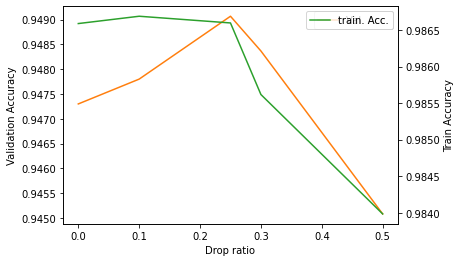

In [ ]:
fig, ax = plt.subplots() 

ax2 = ax.twinx()

drop_cv.plot(x = "drop_ratio", y = "valid_acc", kind='line', color='C1', ax=ax, label="Val. Acc.")
drop_cv.plot(x = "drop_ratio", y = "train_acc", kind='line', color='C2', ax=ax2, label="train. Acc.")
ax.set_xlabel("Drop ratio")
ax.set_ylabel('Validation Accuracy')
ax2.set_ylabel('Train Accuracy')

Text(0, 0.5, 'Train Accuracy')

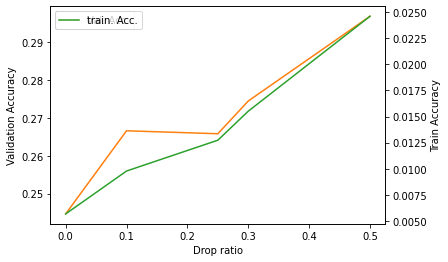

In [ ]:
fig, ax = plt.subplots() 

ax2 = ax.twinx()

width = 0.2

drop_cv.plot(x = "drop_ratio", y = "valid_loss_min", kind='line', color='C1', ax=ax, label="Val. Loss.")
drop_cv.plot(x = "drop_ratio", y = "train_loss", kind='line', color='C2', ax=ax2, label="train. Loss.")
ax.set_xlabel("Drop ratio")
ax.set_ylabel('Validation Loss')
ax2.set_ylabel('Train Loss')

In [ ]:


fig, ax = plt.subplots() 

ax2 = ax.twinx()

width = 0.2

drop_cv.plot(x = "drop_ratio", y = "valid_acc", kind='line', color='C1', ax=ax, width=width, position=1, label="Val. Acc.")
drop_cv.plot(x = "Network_type", y = "total_time", kind='bar', color='C2', ax=ax2, width=width, position=0,label="Time")
ax.set_xlabel("VGG Type")
ax.set_ylabel('Validation Accuracy')
ax2.set_ylabel('Time [s]')
ax.set_ylim(0.9)
ax.legend(loc=9);
plt.tight_layout()
plt.savefig("plots/vgg_type.pdf", bbox_inches="tight", pad_inches=0)


In [ ]:
# final data

rawdata= {'drop_ratio': dropout, 'train_loss': train_loss, 'train_acc': train_acc,
          'valid_loss_min': valid_loss, 'last_epoch_val_loss': valid_loss_last_epoch, 'valid_acc': valid_acc, 'time/epoch': dur, 
          }
drop_cv = pd.DataFrame(rawdata, columns = ['drop_ratio','train_loss', 'train_acc',
                                            'valid_loss_min', 'last_epoch_val_loss','valid_acc','time/epoch',
                                            ])

# Test weight decay + drop ratio

Fixed parameters:
- VGG-16
- batch size = 32
- learning rate: LRScheduler=ReduceLROnPlateau, initial lr=1e-4
- Optimizer = AdamW
- epochs = 20

Testing parameters:
- drop ratio = 0.25,0.3,0.5
- weight decay = 0.005, 0.01 0.02

In [ ]:
import skorch

weight_decay_pool = [0.005, 0.01, 0.02]
drop_out_pool = [0.25, 0.3, 0.5]
drop = []
weight_decay = []
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []
callbacks = callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                     ))
    ]

for wd in weight_decay_pool:

  for dr in drop_out_pool:

    drop_ratio = dr
    network = VGG_net().to(device)
    torch.manual_seed(0)
    cnn = NeuralNetClassifier(
        network,
        max_epochs=20,
        lr=1e-4,
        optimizer=torch.optim.AdamW,
        optimizer__weight_decay=wd,
        batch_size=32,
        device=device,
        iterator_train__num_workers=4,
        iterator_valid__num_workers=4,
        callbacks=callbacks,
        train_split = skorch.dataset.CVSplit(10)
    )
    print(f"fitting with weight decay of {wd} and drop ratio of {dr}")

    startall = time.time()
    cnn.fit(dataset, y=y_data)
    endall = time.time()
    timeall = endall-startall

    train_loss.append(np.min(cnn.history[:, 'train_loss']))
    valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
    valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
    dur.append(np.average(cnn.history[:, 'dur']))
    drop.append(dr)
    weight_decay.append(wd)
    total_time.append(timeall)
    
    print(f"drop ratio: {dr}")
    print(f"weight decay: {wd}")
    print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
    print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
    print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
    print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
    print(f"Total Time: {timeall:.2f} s")

fitting with weight decay of 0.005 and drop ratio of 0.25
learning rate = 0.0001
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4429       0.6062        1.1083  64.8704


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


learning rate = 0.0001
      2        0.9211       0.7695        0.7227  64.9704
learning rate = 0.0001
      3        0.6211       0.8327        0.5789  64.7473
learning rate = 0.0001
      4        0.4391       0.8950        0.3877  64.3247
learning rate = 0.0001
      5        0.3302       0.8978        0.3779  64.3076
learning rate = 0.0001
      6        0.2583       0.8787        0.5199  64.7483
learning rate = 0.0001
      7        0.2092       0.8918        0.3963  64.4641
learning rate = 0.0001
      8        0.1751       0.9105        0.3789  64.6481
learning rate = 0.0001
      9        0.1512       0.9373        0.2709  64.6969
learning rate = 0.0001
     10        0.1244       0.9387        0.2742  64.8738
learning rate = 0.0001
     11        0.1107       0.9442        0.2387  64.7810
learning rate = 1e-05
     12        0.0460       0.9670        0.1440  64.5995
learning rate = 1e-05
     13        0.0250       0.9690        0.1407  64.3134
learning rate = 1e-05
     14 

In [ ]:
rawdata= {'drop_ratio': drop,'weight_decay': weight_decay, 'train_loss': train_loss, 
          'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 
          'total_time': total_time}
weight_decay_dropout = pd.DataFrame(rawdata, columns = ['drop_ratio','weight_decay','train_loss',
                                            'valid_loss','valid_acc','time/epoch','total_time'])

In [ ]:
weight_decay_dropout

,drop_ratio,weight_decay,train_loss,valid_loss,valid_acc,time/epoch,total_time
0,0.25,0.005,0.003668,0.140723,0.971667,64.639849,1295.397648
1,0.30,0.005,0.004286,0.186233,0.970167,64.705091,1296.712166
2,0.50,0.005,0.010104,0.201967,0.967833,64.741995,1297.569389
3,0.25,0.010,0.004672,0.171801,0.971167,64.755277,1297.747154
4,0.30,0.010,0.004685,0.156763,0.971833,64.811586,1298.888552
5,0.50,0.010,0.012142,0.209047,0.966667,64.791136,1298.472522
6,0.25,0.020,0.005192,0.179316,0.968667,64.645580,1295.463487
7,0.30,0.020,0.005707,0.163688,0.970500,64.142806,1285.274523
8,0.50,0.020,0.010985,0.176050,0.970500,64.243379,1287.356465


In [ ]:
weight_decay_dropout.to_csv("weight_decay_dropout.csv",index=False, header=True)

# Test VGG 11,13,16,19
hypeparameter:

1. learning rate: 1e-4
2. batch size: 32
3. drop_ratio = 0.25
4. kernel_size_CNN = (3, 3)
5. optimizer: Adam
6. LR_scheduler: ReduceLROnPlateau(default)


run for 20 epoch



In [16]:
learning_rate = 1e-4
batch_size = 32
max_epochs = 20

In [17]:
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))
y_data = np.array([y for x, y in iter(dataset)])

In [18]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import Callback




#  callbacks function to check and change lr 
callbacks=[
           ('lr_scheduler',
            LRScheduler(
                policy=ReduceLROnPlateau, 
                monitor = "train_loss",
                )
            )
          ]
          
Network_type = ["VGG11", "VGG13", "VGG16", "VGG19"]
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []


In [19]:
for i in Network_type:

  print ("testing: ", i, " now")
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types[i]).to(device)

  cnn = NeuralNetClassifier(
      network,
      max_epochs = max_epochs,
      lr= learning_rate,

      # AdamW
      optimizer = torch.optim.Adam,
      # optimizer__weight_decay=weight_decay,

      batch_size = 32,
      device=device,
      iterator_train__num_workers = 4,
      iterator_valid__num_workers = 4,
      callbacks=callbacks,
  )

  # record start time
  startall = time.time()

  # training
  cnn.fit(dataset, y=y_data)

  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  total_time.append(timeall)
  
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

testing:  VGG11  now
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4828       0.4818        1.2965  59.9495


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        0.8756       0.7857        0.6647  60.6434
      3        0.5055       0.8208        0.5734  60.0242
lowest train loss: 0.5054536774843321
lowest valid loss: 0.5734252993407775
max valid accuracy: 0.820839580209895
time per epoch: 60.20568974812826
Total Time: 190.09 s
testing:  VGG13  now


KeyError: ignored

In [ ]:
import pandas as pd
rawdata= {'Network_type': Network_type, 'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 'total_time': total_time}
VGG_compare = pd.DataFrame(rawdata, columns = ['Network_type','train_loss','valid_loss','valid_acc','time/epoch','total_time'])
print (VGG_compare)

In [ ]:
VGG_compare.to_csv("VGG_compare.csv",index=False, header=True)

# Test optimizer: Adam, AdamW, SGD_momentum, SGD_momentum_nesterov
hypeparameter:

1. learning rate: 1e-4
2. batch size: 32
3. drop_ratio = 0.25
4. kernel_size_CNN = (3, 3)
5. structure : VGG-16
6. LR_scheduler: ReduceLROnPlateau(default)

run for 20 epoch

# optimizer hyperparmeter

1. Adam
2. Adam: weight decay = 1e-3
3. SGD_momentum: momentum =0.99, weight decay = 1e-3
4. SGD_momentum_nesterov : momentum =0.99, weight decay = 1e-3, nesterov = true



In [ ]:
learning_rate = 1e-4
batch_size = 32
max_epochs = 20

In [ ]:
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))
y_data = np.array([y for x, y in iter(dataset)])

In [ ]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import Callback

torch.manual_seed(0)

#  callbacks function to check and change lr 
callbacks=[
           ('lr_scheduler',
            LRScheduler(
                policy=ReduceLROnPlateau, 
                monitor = "train_loss",
                )
            )
          ]
          
optimizer_type = ["Adam", "AdamW", "SGD_momentum", "SGD_momentum_nesterov"]
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []


In [ ]:
for i in optimizer_type:

  print ("testing: ", i, " now")
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)

  if (i=="Adam"):
    cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "AdamW"):
     cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.AdamW,
        optimizer__weight_decay=weight_decay,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "SGD_momentum"):
     cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.SGD,
        optimizer__weight_decay = weight_decay,
        optimizer__momentum = 0.9,
        optimizer__nesterov = False,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "SGD_momentum_nesterov"):
    cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.SGD,
        optimizer__weight_decay = weight_decay,
        optimizer__momentum = 0.9,
        optimizer__nesterov = True,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )

  # record start time
  startall = time.time()

  # training
  cnn.fit(dataset, y=y_data)

  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  total_time.append(timeall)
  
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

In [ ]:
import pandas as pd
rawdata= {'optimizer_type': optimizer_type, 'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 'total_time': total_time}
VGG_compare = pd.DataFrame(rawdata, columns = ['optimizer_type','train_loss','valid_loss','valid_acc','time/epoch','total_time'])
print (VGG_compare)

In [ ]:
VGG_compare.to_csv("optimizer_compare.csv",index=False, header=True)

Wait until SGD converges...

In [ ]:
optimizer_type = ["SGD_momentum", "SGD_momentum_nesterov"]

train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []

In [ ]:
max_epochs = 50

callbacks=[
        ('lr_scheduler',
        LRScheduler(
            policy=ReduceLROnPlateau, 
            factor = 0.5,
            monitor = "train_loss",
            )
        )
      ]


for i in optimizer_type:

  print ("testing: ", i, " now")
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)

  if (i=="Adam"):
    cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.Adam,
        batch_size = 20,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "AdamW"):
     cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.AdamW,
        optimizer__weight_decay=weight_decay,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "SGD_momentum"):
     cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.SGD,
        optimizer__weight_decay = 0,
        optimizer__momentum = 0,
        optimizer__nesterov = False,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  elif (i == "SGD_momentum_nesterov"):
    cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.SGD,
        optimizer__weight_decay = 0,
        optimizer__momentum = 0,
        optimizer__nesterov = True,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )

  # record start time
  startall = time.time()

  # training
  cnn.fit(dataset, y=y_data)

  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  total_time.append(timeall)
  
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

In [ ]:
import pandas as pd
rawdata= {'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 'total_time': total_time}
VGG_compare = pd.DataFrame(rawdata, columns = ['train_loss','valid_loss','valid_acc','time/epoch','total_time'])
print (VGG_compare)

# Test LR_scheduler: CyclicLR_triangular
hypeparameter:

1. learning rate: 1e-4
2. batch size: 32
3. drop_ratio = 0.25
4. kernel_size_CNN = (3, 3)
5. structure : VGG-16
6. optimizer : Adam


run for 20 epoch

# LR_scheduler hyperparmeter
referecne: https://medium.com/swlh/cyclical-learning-rates-the-ultimate-guide-for-setting-learning-rates-for-neural-networks-3104e906f0ae

fixed parameter without momentum

base_lr = 1e-5,
max_lr = 1e-4,
step_size_up = 5,


1. CyclicLR_triangular
2. CyclicLR_triangular2
3. CyclicLR_exp_range




In [ ]:
learning_rate = 1e-4
batch_size = 32
max_epochs = 20

In [ ]:
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))
y_data = np.array([y for x, y in iter(dataset)])

In [ ]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import Callback

class Monitor(Callback):
    def on_epoch_end(self, network, **kwargs):
      print("current learning rate: ", network.optimizer_.param_groups[0]['lr'])

torch.manual_seed(0) 
CyclicLR_type = ["CyclicLR_triangular", "CyclicLR_triangular2", "CyclicLR_exp_range"]
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []


In [ ]:
for i in CyclicLR_type:

  print ("testing: ", i, " now")
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)

  if (i=="CyclicLR_triangular"):
    callbacks=[
        ('print', Monitor()), 
        ('lr_scheduler',
        LRScheduler(
            policy=torch.optim.lr_scheduler.CyclicLR, 
            base_lr = 1e-5,
            max_lr = 1e-4,
            step_size_up = 5,
            cycle_momentum=False,
            mode='triangular',
            monitor = "train_loss",
            )
        )
      ]
  elif (i == "CyclicLR_triangular2"):
    callbacks=[
        ('print', Monitor()), 
        ('lr_scheduler',
        LRScheduler(
            policy=torch.optim.lr_scheduler.CyclicLR, 
            base_lr = 1e-5,
            max_lr = 1e-4,
            step_size_up = 5,
            cycle_momentum=False,
            mode='triangular2',
            monitor = "train_loss",
            )
        )
      ]
  elif (i == "CyclicLR_exp_range"):
    callbacks=[
        ('print', Monitor()), 
        ('lr_scheduler',
        LRScheduler(
            policy=torch.optim.lr_scheduler.CyclicLR, 
            base_lr = 1e-5,
            max_lr = 1e-4,
            step_size_up = 5,
            cycle_momentum=False,
            mode='exp_range',
            monitor = "train_loss",
            )
        )
      ]

  cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  # record start time
  startall = time.time()

  # training
  cnn.fit(dataset, y=y_data)

  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  total_time.append(timeall)
  
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

In [ ]:
import pandas as pd
rawdata= {'CyclicLR_type': CyclicLR_type, 'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 'total_time': total_time}
VGG_compare = pd.DataFrame(rawdata, columns = ['CyclicLR_type','train_loss','valid_loss','valid_acc','time/epoch','total_time'])
print (VGG_compare)

In [ ]:
VGG_compare.to_csv("CyclicLR_type_compare.csv",index=False, header=True)

# Test LR_scheduler: ReduceLROnPlateau
hypeparameter:

1. learning rate: 1e-4
2. batch size: 32
3. drop_ratio = 0.25
4. kernel_size_CNN = (3, 3)
5. structure : VGG-16
6. optimizer : Adam


run for 20 epoch

# ReduceLROnPlateau hyperparmeter

1. ReduceLROnPlateau_default
2. ReduceLROnPlateau_fatcor_0.9_patience_4
3. ReduceLROnPlateau_fatcor_0.5_patience_4





In [ ]:
learning_rate = 1e-4
batch_size = 32
max_epochs = 20

In [ ]:
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))
y_data = np.array([y for x, y in iter(dataset)])

In [ ]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import Callback

torch.manual_seed(0)
          
ReduceLROnPlateau_type = ["ReduceLROnPlateau_default", "ReduceLROnPlateau_fatcor_0.9_patience_4", "ReduceLROnPlateau_fatcor_0.5_patience_4"]
train_loss = []
valid_loss = []
valid_acc = []
dur = []
total_time = []


In [ ]:
for i in ReduceLROnPlateau_type:

  print ("testing: ", i, " now")
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)

  if (i=="ReduceLROnPlateau_default"):
    callbacks=[
           ('lr_scheduler',
            LRScheduler(
                policy=ReduceLROnPlateau, 
                monitor = "train_loss",
                )
            )
          ]
  elif (i == "ReduceLROnPlateau_fatcor_0.9_patience_4"):
    callbacks=[
           ('lr_scheduler',
            LRScheduler(
                policy=ReduceLROnPlateau, 
                factor = 0.9,
                patience = 4, 
                monitor = "train_loss",
                )
            )
          ]
  elif (i == "ReduceLROnPlateau_fatcor_0.5_patience_4"):
    callbacks=[
           ('lr_scheduler',
            LRScheduler(
                policy=ReduceLROnPlateau, 
                factor = 0.5,
                patience = 4, 
                monitor = "train_loss",
                )
            )
          ]

  cnn = NeuralNetClassifier(
        network,
        max_epochs = max_epochs,
        lr= learning_rate,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        device=device,
        iterator_train__num_workers = 4,
        iterator_valid__num_workers = 4,
        callbacks=callbacks,
    )
  # record start time
  startall = time.time()

  # training
  cnn.fit(dataset, y=y_data)

  endall = time.time()
  timeall = endall-startall

  train_loss.append(np.min(cnn.history[:, 'train_loss']))
  valid_loss.append(np.min(cnn.history[:, 'valid_loss']))
  valid_acc.append(np.max(cnn.history[:, 'valid_acc']))
  dur.append(np.average(cnn.history[:, 'dur']))
  total_time.append(timeall)
  
  print(f"lowest train loss: {np.min(cnn.history[:, 'train_loss'])}")
  print(f"lowest valid loss: {np.min(cnn.history[:, 'valid_loss'])}")
  print(f"max valid accuracy: {np.max(cnn.history[:, 'valid_acc'])}")
  print(f"time per epoch: {np.average(cnn.history[:, 'dur'])}")
  print(f"Total Time: {timeall:.2f} s")

In [ ]:
import pandas as pd
rawdata= {'ReduceLROnPlateau_type': ReduceLROnPlateau_type, 'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_acc': valid_acc, 'time/epoch': dur, 'total_time': total_time}
VGG_compare = pd.DataFrame(rawdata, columns = ['ReduceLROnPlateau_type','train_loss','valid_loss','valid_acc','time/epoch','total_time'])
print (VGG_compare)

In [ ]:
VGG_compare.to_csv("ReduceLROnPlateau_type_compare.csv",index=False, header=True)